# Imports

In [1]:
import pandas as pd
import networkx as nx
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import os
import pickle
from tqdm import tqdm
import analysis_util
import nltk 
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon", "punkt"])

# Data

In [2]:
subreddits = ['FourSentenceStories','Trump666','GraphTheory','jazznoir','indoorbouldering','kiwi_bird','DTU']
period = '2015-01-01-2022-01-01'

df_post_dict = {}
df_comment_dict = {}
df_all_nodes_dict = {}
G_dict = {}
G_di_dict = {}
df_authors_dict = {}
df_comment_post_dict = {}


for subreddit in subreddits:
    print(subreddit)
    path_post='../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_posts.csv"
    path_comment = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_comments.csv"
    path_awards = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards.csv"
    path_awards_comments = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards_comments.csv"
    
    df_comments=analysis_util.read_comments(path_comment,path_awards_comments)
    df_post=analysis_util.read_posts(path_post,path_awards)
    df_all_nodes=analysis_util.get_all_nodes(df_post,df_comments)    
    df_comment_post = analysis_util.get_comment_post_date(df_comments,df_post)
    # df_authors = analysis_util.get_authors(G,df_all_nodes,df_comments,df_post,df_comment_post)
    
    df_comment_post_dict[subreddit] = df_comment_post
    df_comment_dict[subreddit] = df_comments
    df_post_dict[subreddit] = df_post
    df_all_nodes_dict[subreddit] = df_all_nodes
    # df_authors_dict[subreddit] = df_authors
    print('')

FourSentenceStories
Removed 0.008264462809917328 of the rows

Trump666
Removed 0.023008849557522026 of the rows

GraphTheory
Removed 0.046391752577319645 of the rows

jazznoir
Removed 0.056192660550458795 of the rows

indoorbouldering
Removed 0.013580246913580174 of the rows

kiwi_bird
Removed 0.01412429378531077 of the rows

DTU
Removed 0.02263374485596703 of the rows



In [3]:
for subreddit in subreddits:
    df_comment_dict[subreddit]['n_awards'] = df_comment_dict[subreddit]['n_awards'].astype(int)
    df_comment_dict[subreddit]['award'] = df_comment_dict[subreddit]['n_awards'] > 0

    df_post_dict[subreddit]['n_awards'] = df_post_dict[subreddit]['n_awards'].fillna(0)
    df_post_dict[subreddit]['n_awards'] = df_post_dict[subreddit]['n_awards'].astype(int)
    df_post_dict[subreddit]['award'] = df_post_dict[subreddit]['n_awards'] > 0

In [4]:
for subreddit in subreddits:
    if 'text' in df_comment_dict[subreddit].columns:
        # rename text column name
        df_comment_dict[subreddit] = df_comment_dict[subreddit].rename(columns={'text':'body'})

In [5]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/graph_features_2/'
file_names=os.listdir(p)

data = []

for name in file_names:
    data.append(pd.read_csv(p+name))

df_gf=pd.concat(data)

df_balanced = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/balanced_data_chunked10.csv')

df_gf.drop_duplicates(inplace=True)
df=df_balanced.join(df_gf.set_index('id'),on='id')
df.dropna(subset='degree',inplace=True)
df=df[['author', 'date', 'score', 'n_comments', 'id',
       'n_awards', 'text_title', 'degree_cen', 'close_cen', 
       'activity', 'degree', 'N_nodes', 'N_edges','mentions']]

df.loc[df.n_awards==0,'awarded']=0
df.loc[df.n_awards!=0,'awarded']=1

df['n_comments']=df.n_comments.apply(lambda x: np.sqrt(x**2))

df['date'] = pd.to_datetime(df['date'])

def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan

def text_length(text):
    if type(text) == str:
        return len(text)
    else:
        return np.nan

df['sentiment_compound']=df['text_title'].apply(lambda x: get_sentiment(x))
df['text_length']=df['text_title'].apply(lambda x: text_length(x))

# common words

In [6]:
# # most said words
# stop_words = set(stopwords.words('english'))

# def get_most_common_words(df,df_comment, n=10):
#     words = []
#     df1 = df['text'].apply(lambda x: '' if pd.isna(x) else x) + ' ' + df['title']
#     df2 = df_comment['body']
#     for text in pd.concat([df1, df2], axis=0):
#         if isinstance(text, str):
#             text = text.lower()
#             text = text.translate(str.maketrans('', '', string.punctuation))
#             text = text.translate(str.maketrans('', '', string.digits))
#             text = text.translate(str.maketrans('', '', '“'))
#             text = text.translate(str.maketrans('', '', '”'))
#             text = text.translate(str.maketrans('', '', '’'))
#             word_tokens = word_tokenize(text)
#             words.extend(word_tokens)
#         words = [w for w in words if not w in stop_words]
#         word_count = Counter(words)
#     return word_count.most_common(n)

# # plot most common words
# def plot_most_common_words(df,df_comment, n=10, subreddit=subreddit):
#     plt.figure(figsize=(10, 5))
#     word_count = get_most_common_words(df, df_comment, n)
#     words = [w[0] for w in word_count]
#     counts = [w[1] for w in word_count]
#     plt.figure(figsize=(10,5))
#     plt.bar(words, counts)
#     plt.title('Most common words in ' + subreddit)
#     plt.show()

# for subreddit in subreddits:
#     plot_most_common_words(df_post_dict[subreddit], df_comment_dict[subreddit], 10,subreddit)

# TF-IDF

# Sentiment

/tmp/ipykernel_9198/1051660834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t.awarded=df_t.awarded.astype(str)
/tmp/ipykernel_9198/1051660834.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t.awarded=df_t.awarded.replace('0.0','not awarded')
/tmp/ipykernel_9198/1051660834.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

<Figure size 1500x800 with 0 Axes>

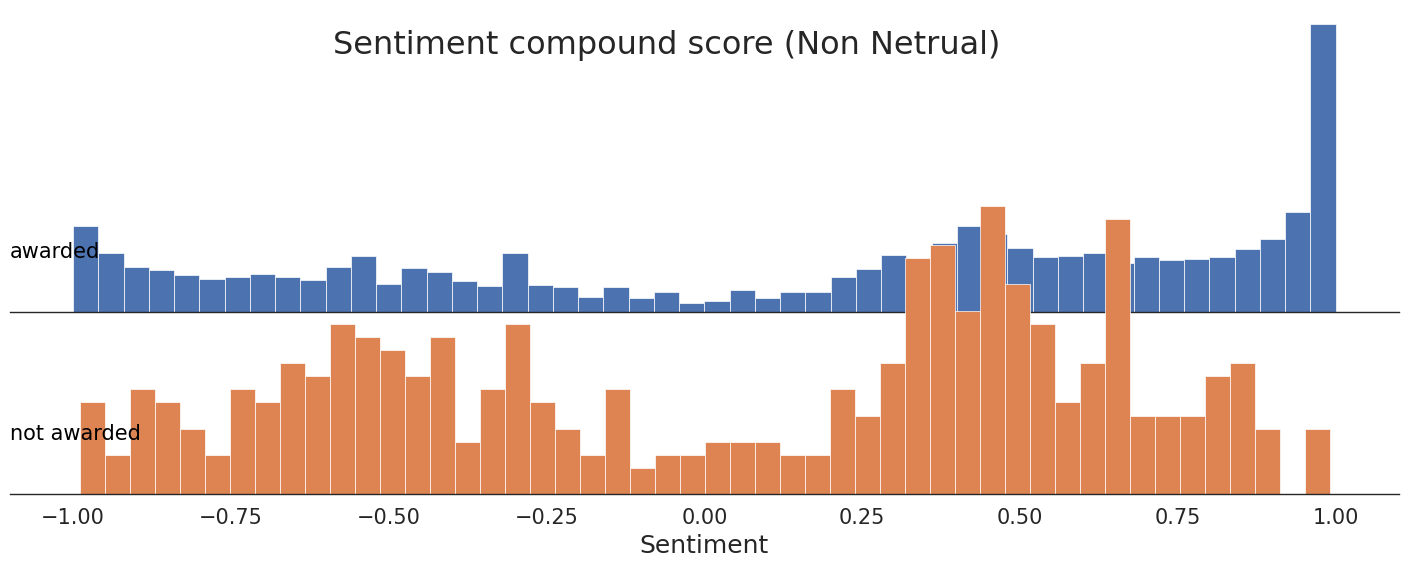

In [7]:
df_t=df[df['sentiment_compound']!=0]
# df_t.awarded change to string
df_t.awarded=df_t.awarded.astype(str)
df_t.awarded=df_t.awarded.replace('0.0','not awarded')
df_t.awarded=df_t.awarded.replace('1.0','awarded')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':1})
fig = plt.figure(figsize=(15, 8))

# use color_dict to set color
g = sns.FacetGrid(df_t, row="awarded", hue="awarded", aspect=5, height=3,sharex=True,sharey=False)
# xtics size
plt.xticks(fontsize=15)
g.map(sns.histplot, "sentiment_compound", bins=50, alpha=1, linewidth=0.5, edgecolor="white", cumulative=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=15,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "awarded")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
# g.set(yticks=[], xlabel="IMDB Score")
g.despine( left=True)
# remove x axis and y axis
g.axes[0,0].axes.yaxis.set_visible(False)
g.axes[1,0].axes.yaxis.set_visible(False)


# more space between subplots
g.fig.subplots_adjust(hspace=-0.4)
# set x axis label

g.axes[1,0].axes.set_xlabel('Sentiment',fontsize=18)
plt.suptitle('Sentiment compound score (Non Netrual)', y=0.90, fontsize=23)
plt.show()

/tmp/ipykernel_9198/1263485099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t.awarded=df_t.awarded.astype(str)
/tmp/ipykernel_9198/1263485099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t.awarded=df_t.awarded.replace('0.0','not awarded')
/tmp/ipykernel_9198/1263485099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

<Figure size 1500x800 with 0 Axes>

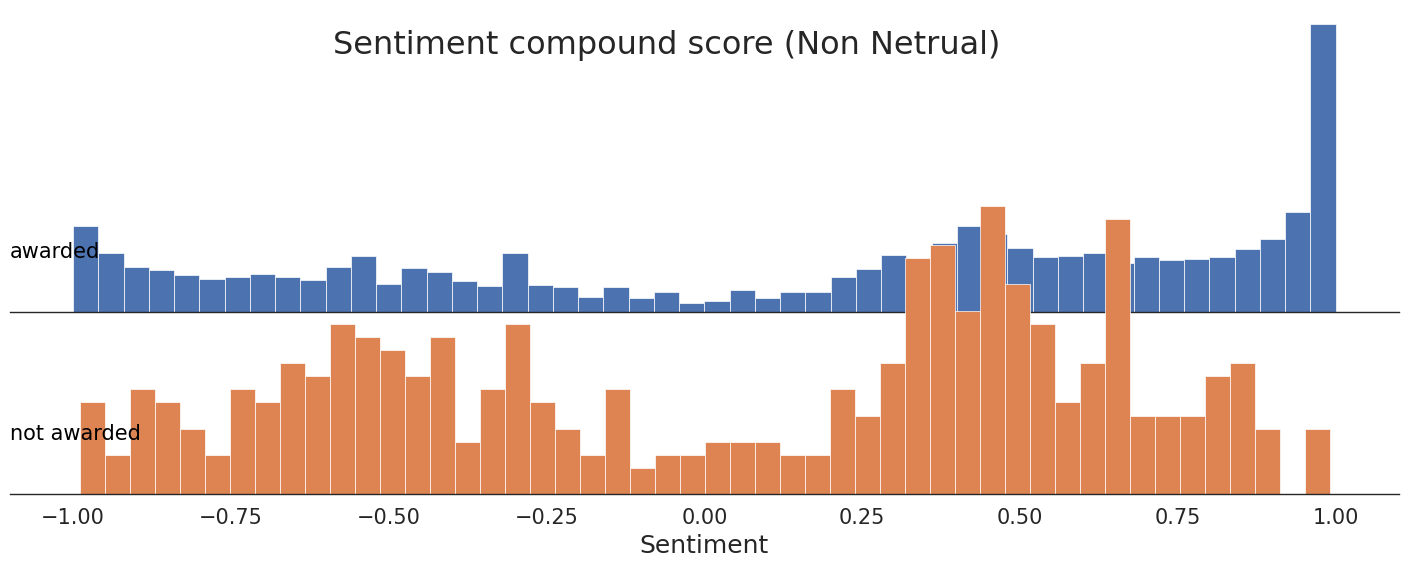

In [8]:
# df_t.awarded change to string
df_t.awarded=df_t.awarded.astype(str)
df_t.awarded=df_t.awarded.replace('0.0','not awarded')
df_t.awarded=df_t.awarded.replace('1.0','awarded')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':1})
fig = plt.figure(figsize=(15, 8))

# use color_dict to set color
g = sns.FacetGrid(df_t, row="awarded", hue="awarded", aspect=5, height=3,sharex=True,sharey=False)
# xtics size
plt.xticks(fontsize=15)
g.map(sns.histplot, "sentiment_compound", bins=50, alpha=1, linewidth=0.5, edgecolor="white", cumulative=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=15,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "awarded")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
# g.set(yticks=[], xlabel="IMDB Score")
g.despine( left=True)
# remove x axis and y axis
g.axes[0,0].axes.yaxis.set_visible(False)
g.axes[1,0].axes.yaxis.set_visible(False)


# more space between subplots
g.fig.subplots_adjust(hspace=-0.4)
# set x axis label

g.axes[1,0].axes.set_xlabel('Sentiment',fontsize=18)
plt.suptitle('Sentiment compound score (Non Netrual)', y=0.90, fontsize=23)
plt.show()

In [9]:
def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan

subreddits = ['FourSentenceStories','Trump666','GraphTheory','jazznoir','indoorbouldering','kiwi_bird','DTU']
for subreddit in tqdm(subreddits):
    df_post_dict[subreddit]['title_sentiment'] = df_post_dict[subreddit]['title'].apply(lambda x: get_sentiment(x))
    df_post_dict[subreddit]['text_sentiment'] = df_post_dict[subreddit]['text'].apply(lambda x: get_sentiment(x))
    df_comment_dict[subreddit]['sentiment'] = df_comment_dict[subreddit]['body'].apply(lambda x: get_sentiment(x))

100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


<Figure size 1500x1500 with 0 Axes>

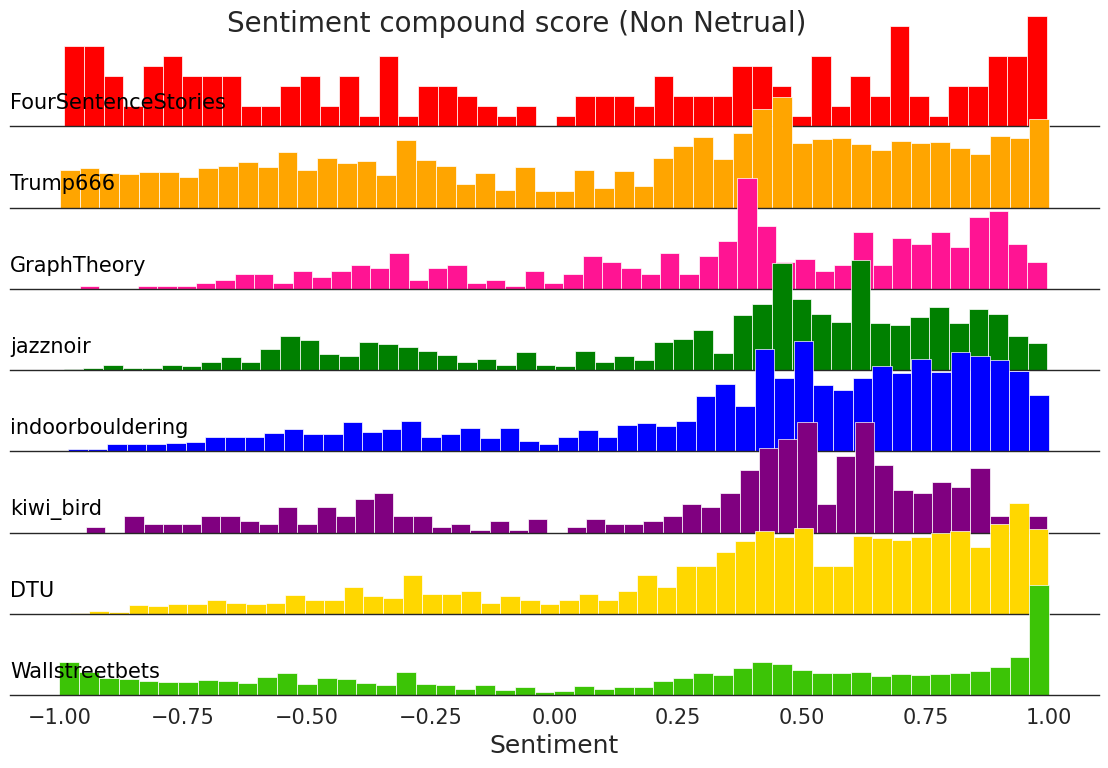

In [10]:
subreddits = ['FourSentenceStories','Trump666','GraphTheory','jazznoir','indoorbouldering','kiwi_bird','DTU','Wallstreetbets']
df_wall=df.copy()
color_dict = {'FourSentenceStories':'#FF0000','Trump666':'#FFA500','GraphTheory':'#FF1493','jazznoir':'#008000',
'indoorbouldering':'#0000FF','kiwi_bird':'#800080',
'DTU':'#FFD700','Wallstreetbets': '#3cc406'}

df_all_sentiment = pd.DataFrame()
for sub in subreddits:
    if sub == 'Wallstreetbets':
        df_wall['sentiment'] = df_wall['sentiment_compound']
        df_wall = df_wall['sentiment']
        sentiments = df_wall
        sentiments=pd.DataFrame(sentiments)
        sentiments['subreddit'] = 'Wallstreetbets'
    else:
        sentiments=pd.concat([df_post_dict[sub]['title_sentiment'].dropna(),df_comment_dict[sub]['sentiment'].dropna(),df_post_dict[sub]['text_sentiment'].dropna()])
        sentiments=pd.DataFrame(sentiments)
        sentiments['subreddit']=sub
        sentiments.columns=['sentiment','subreddit']
    df_all_sentiment=pd.concat([df_all_sentiment,sentiments],axis=0)

df_all_sentiment.columns=['sentiment','subreddit']
df_all_sentiment=df_all_sentiment[df_all_sentiment['sentiment']!=0]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':1})
fig = plt.figure(figsize=(15, 15))

# use color_dict to set color
g = sns.FacetGrid(df_all_sentiment, row="subreddit", hue="subreddit", aspect=12, height=1, palette=color_dict,sharex=True,sharey=False)
# xtics size
plt.xticks(fontsize=15)
g.map(sns.histplot, "sentiment", bins=50, alpha=1, linewidth=0.5, edgecolor="white", cumulative=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=15,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "subreddit")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
# g.set(yticks=[], xlabel="IMDB Score")
g.despine( left=True)
# remove x axis and y axis
g.axes[0,0].axes.yaxis.set_visible(False)
g.axes[1,0].axes.yaxis.set_visible(False)
g.axes[2,0].axes.yaxis.set_visible(False)
g.axes[3,0].axes.yaxis.set_visible(False)
g.axes[4,0].axes.yaxis.set_visible(False)
g.axes[5,0].axes.yaxis.set_visible(False)
g.axes[6,0].axes.yaxis.set_visible(False)
g.axes[7,0].axes.yaxis.set_visible(False)

# more space between subplots
g.fig.subplots_adjust(hspace=-0.3)
# set x axis label

g.axes[7,0].axes.set_xlabel('Sentiment',fontsize=18)
plt.suptitle('Sentiment compound score (Non Netrual)', y=0.95, fontsize=20)
plt.show()

<Figure size 1500x1500 with 0 Axes>

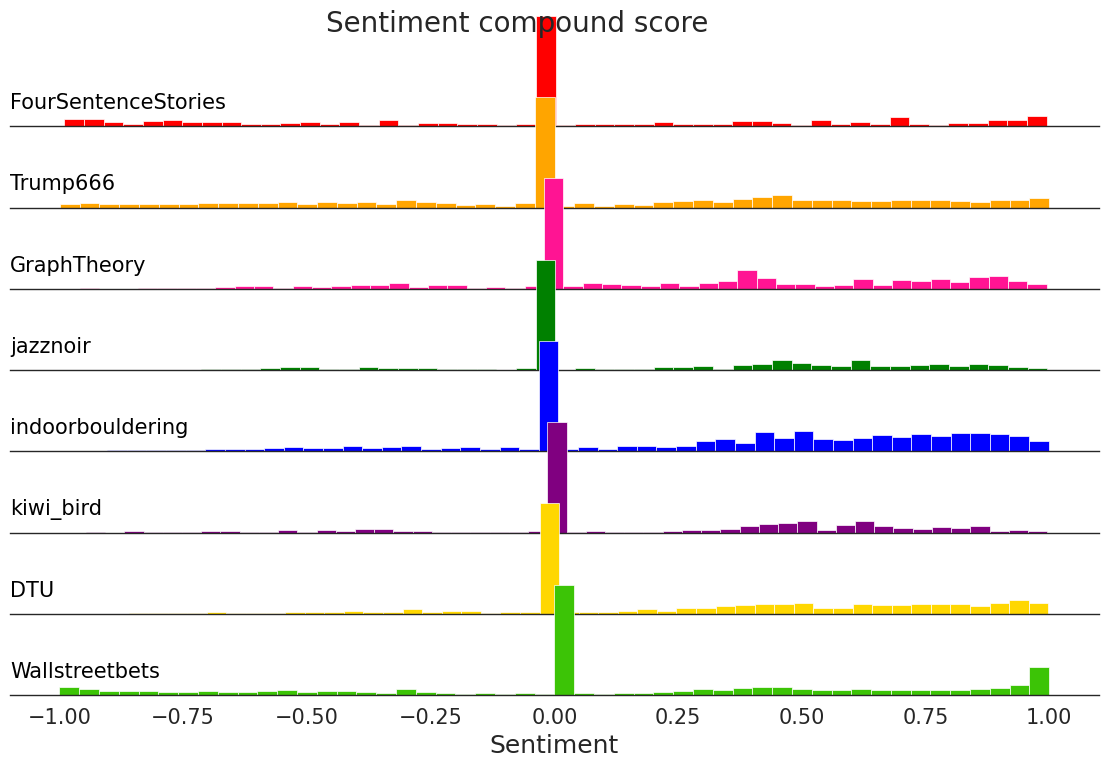

In [11]:
subreddits = ['FourSentenceStories','Trump666','GraphTheory','jazznoir','indoorbouldering','kiwi_bird','DTU','Wallstreetbets']
df_wall=df.copy()
color_dict = {'FourSentenceStories':'#FF0000','Trump666':'#FFA500','GraphTheory':'#FF1493','jazznoir':'#008000',
'indoorbouldering':'#0000FF','kiwi_bird':'#800080',
'DTU':'#FFD700','Wallstreetbets': '#3cc406'}

df_all_sentiment = pd.DataFrame()
for sub in subreddits:
    if sub == 'Wallstreetbets':
        df_wall['sentiment'] = df_wall['sentiment_compound']
        df_wall = df_wall['sentiment']
        sentiments = df_wall
        sentiments=pd.DataFrame(sentiments)
        sentiments['subreddit'] = 'Wallstreetbets'
    else:
        sentiments=pd.concat([df_post_dict[sub]['title_sentiment'].dropna(),df_comment_dict[sub]['sentiment'].dropna(),df_post_dict[sub]['text_sentiment'].dropna()])
        sentiments=pd.DataFrame(sentiments)
        sentiments['subreddit']=sub
        sentiments.columns=['sentiment','subreddit']
    df_all_sentiment=pd.concat([df_all_sentiment,sentiments],axis=0)

df_all_sentiment.columns=['sentiment','subreddit']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':1})
fig = plt.figure(figsize=(15, 15))

# use color_dict to set color
g = sns.FacetGrid(df_all_sentiment, row="subreddit", hue="subreddit", aspect=12, height=1, palette=color_dict,sharex=True,sharey=False)
# xtics size
plt.xticks(fontsize=15)
g.map(sns.histplot, "sentiment", bins=50, alpha=1, linewidth=0.5, edgecolor="white", cumulative=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=15,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "subreddit")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
# g.set(yticks=[], xlabel="IMDB Score")
g.despine( left=True)
# remove x axis and y axis
g.axes[0,0].axes.yaxis.set_visible(False)
g.axes[1,0].axes.yaxis.set_visible(False)
g.axes[2,0].axes.yaxis.set_visible(False)
g.axes[3,0].axes.yaxis.set_visible(False)
g.axes[4,0].axes.yaxis.set_visible(False)
g.axes[5,0].axes.yaxis.set_visible(False)
g.axes[6,0].axes.yaxis.set_visible(False)
g.axes[7,0].axes.yaxis.set_visible(False)

# more space between subplots
g.fig.subplots_adjust(hspace=-0.3)
# set x axis label

g.axes[7,0].axes.set_xlabel('Sentiment',fontsize=18)
plt.suptitle('Sentiment compound score', y=0.95, fontsize=20)
plt.show()

<Figure size 1500x1500 with 0 Axes>

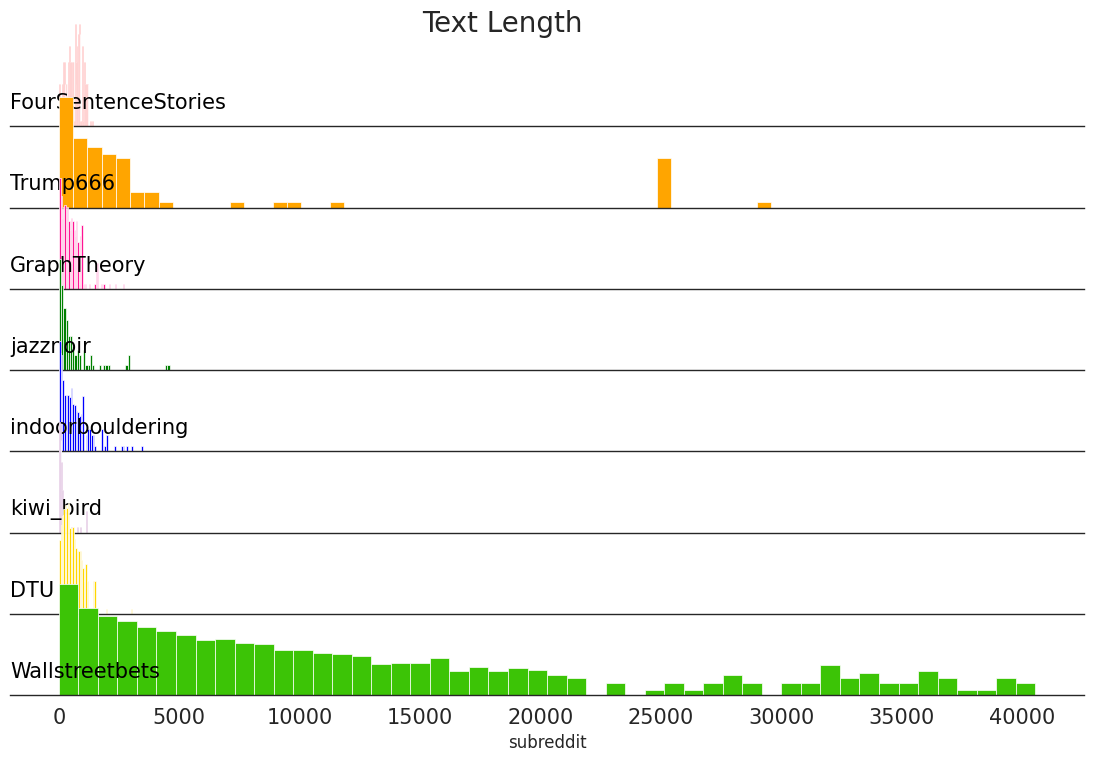

In [12]:
def t_len(txt):
    if type(txt) == str: 
        return len(txt)
    else:
        return 0

df_text_length = pd.DataFrame()

for sub in subreddits:
    if sub == 'Wallstreetbets':
        d=df['text_length']
        d.columns=['text_length']
    else:
        d=df_post_dict[sub]['title'].apply(lambda x: len(x))+df_post_dict[sub]['text'].apply(lambda x: t_len(x))
        d.rename('text_length',inplace=True)

    d=pd.DataFrame(d)
    d['subreddit']=sub
    df_text_length=pd.concat([df_text_length,d],axis=0)



sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':1})
fig = plt.figure(figsize=(15, 15))

# use color_dict to set color
g = sns.FacetGrid(df_text_length, row="subreddit", hue="subreddit", aspect=12, height=1, palette=color_dict,sharex=True,sharey=False)
# xtics size
plt.xticks(fontsize=15)
g.map(sns.histplot, "text_length", bins=50, alpha=1, linewidth=0.5, edgecolor="white", cumulative=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=15,
            ha="left", va="center", transform=ax.transAxes)

# y scale log
g.set(yscale="log")


g.map(label, "subreddit")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.despine( left=True)
# remove x axis and y axis
g.axes[0,0].axes.yaxis.set_visible(False)
g.axes[1,0].axes.yaxis.set_visible(False)
g.axes[2,0].axes.yaxis.set_visible(False)
g.axes[3,0].axes.yaxis.set_visible(False)
g.axes[4,0].axes.yaxis.set_visible(False)
g.axes[5,0].axes.yaxis.set_visible(False)
g.axes[6,0].axes.yaxis.set_visible(False)
g.axes[7,0].axes.yaxis.set_visible(False)

# more space between subplots
g.fig.subplots_adjust(hspace=-0.3)
# set x axis label

g.axes[6,0].axes.set_xlabel('Text Length',fontsize=18)
plt.suptitle('Text Length', y=0.95, fontsize=20)
plt.show()

In [13]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/network_features/'
file_names=os.listdir(p)

data = []
for name in file_names:
    data.append(pd.read_csv(p+name))

df_gf=pd.concat(data)
df_balanced = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/balanced_data_chunked10.csv')

df_gf.drop_duplicates(inplace=True)
df=df_balanced.join(df_gf.set_index('id'),on='id')
df.dropna(subset='degree',inplace=True)
df=df[['author', 'date', 'score', 'n_comments', 'id',
       'n_awards', 'text_title', 'degree_cen',
       	'close_cen','activity',	'degree','N_nodes',
        'N_edges','mentions','frac_rec',	
        'degree_in','degree_out','N_rec_author','N_rec']]

df.loc[df.n_awards==0,'awarded']=0
df.loc[df.n_awards!=0,'awarded']=1

df['n_comments']=df.n_comments.apply(lambda x: np.sqrt(x**2))
df['date'] = pd.to_datetime(df['date'])

def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan

def text_length(text):
    if type(text) == str:
        return len(text)
    else:
        return np.nan

df['sentiment_compound']=df['text_title'].apply(lambda x: get_sentiment(x))
df['text_length']=df['text_title'].apply(lambda x: text_length(x))

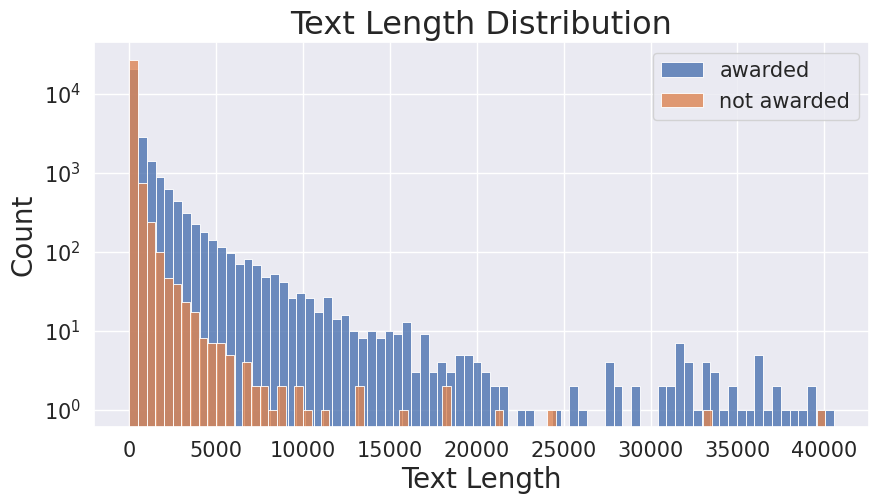

Mean awarded:  794.6105345187914
Mean not awarded:  137.6462010197169


In [19]:
sns.set_theme()
plt.figure(figsize=(10, 5))
sns.histplot(df[df['awarded']==1]['text_length'],bins=80,label='awarded',alpha=0.8,color=sns.color_palette()[0])
sns.histplot(df[df['awarded']==0]['text_length'],bins=80,label='not awarded',alpha=0.8,color=sns.color_palette()[1])

plt.title('Text Length Distribution',fontsize=23)
plt.xlabel('Text Length',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('/home/pelle/Master_Thesis/reports/figures/text_length_awarded.png',dpi=250,bbox_inches='tight')
plt.show()

print('Mean awarded: ',df[df['awarded']==1]['text_length'].mean())
print('Mean not awarded: ',df[df['awarded']==0]['text_length'].mean())

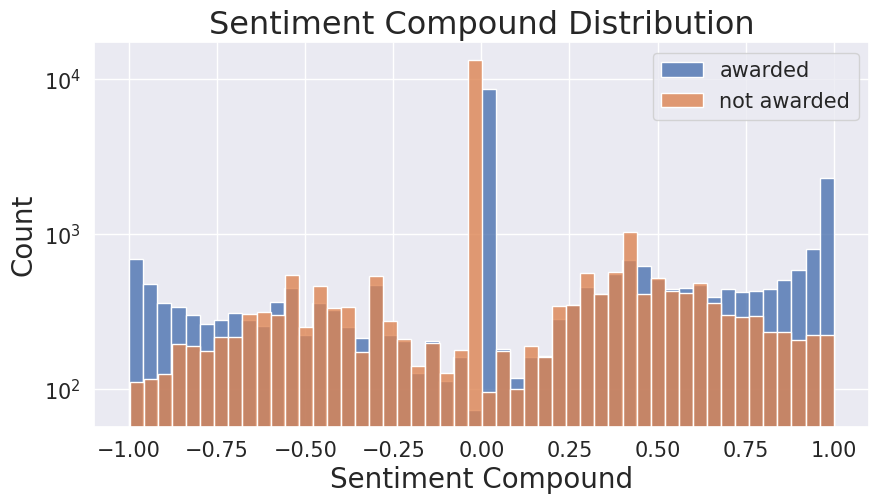

In [15]:
plt.figure(figsize=(10, 5))
df_t = df
sns.histplot(df_t[df_t['awarded']==1]['sentiment_compound'],bins=50,label='awarded',alpha=0.8,color=sns.color_palette()[0])
sns.histplot(df_t[df_t['awarded']==0]['sentiment_compound'],bins=50,label='not awarded',alpha=0.8,color=sns.color_palette()[1])

plt.title('Sentiment Compound Distribution',fontsize=23)
plt.xlabel('Sentiment Compound',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('/home/pelle/Master_Thesis/reports/figures/sentiment_awarded.png',dpi=250,bbox_inches='tight')
plt.show()

In [16]:
print(len(df_t[df_t['awarded']==1]))
print(len(df_t[df_t['awarded']==0]))

28231
28047


In [17]:
def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan

tt = 'i walked to the store today, stupied me'
pred=classifier(tt)
if pred[0]['label'] == 'POSITIVE':
    print(pred[0]['score']*1)
else:
    print(pred[0]['score']*-1)
print(pred)

print(get_sentiment(tt))

NameError: name 'classifier' is not defined

In [ ]:
1e-3

0.001

In [ ]:
df_all_sentiment.subreddit.value_counts()

Wallstreetbets         20064
indoorbouldering        8365
Trump666                5101
jazznoir                2730
DTU                     2212
kiwi_bird                503
GraphTheory              434
FourSentenceStories      203
Name: subreddit, dtype: int64

In [ ]:
sentiments_a = np.array([])
sentiments_na = np.array([])

for i,sub in enumerate(subreddits):

    sentiments_awarded=pd.concat([
        df_comment_dict[sub].loc[df_comment_dict[sub]['award']==True]['sentiment'].dropna(),
        df_post_dict[sub].loc[df_post_dict[sub]['award']==True]['text_sentiment'].dropna()]).values

    sentiments_not_awarded=pd.concat([
        df_comment_dict[sub].loc[df_comment_dict[sub]['award']==False]['sentiment'].dropna(),
        df_post_dict[sub].loc[df_post_dict[sub]['award']==False]['text_sentiment'].dropna()]).values

    # append to list
    sentiments_a = np.append(sentiments_a, sentiments_awarded)
    sentiments_na = np.append(sentiments_na, sentiments_not_awarded)

KeyError: 'Wallstreetbets'

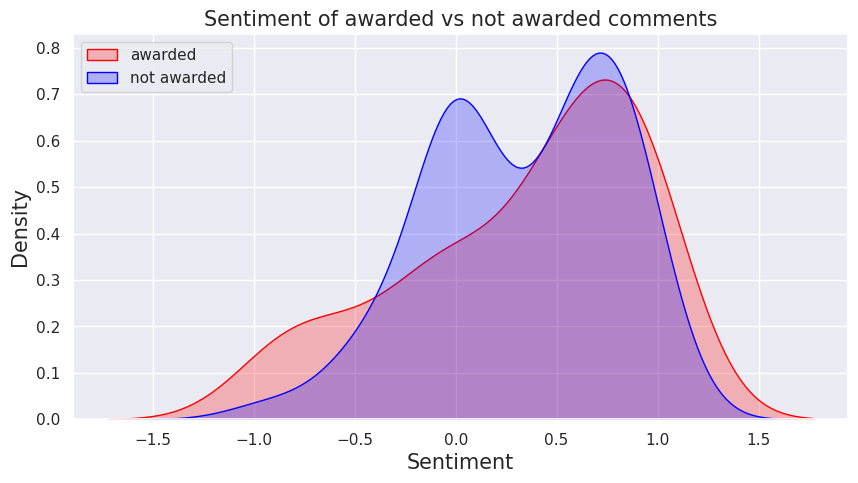

In [ ]:
plt.figure(figsize=(10,5))
sentiments_na_sample = np.random.choice(sentiments_na, len(sentiments_a), replace=False)
# plot the 2 kde
sns.kdeplot(list(sentiments_a), color='red',label='awarded',fill=True)
sns.kdeplot(list(sentiments_na_sample), color='blue',label='not awarded',fill=True)
plt.xlabel('Sentiment',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.legend(loc='upper left')
plt.title('Sentiment of awarded vs not awarded comments',fontsize=15)
plt.show()

# Text length

In [ ]:
words_a = np.array([])
words_na = np.array([])

for sub in subreddits:
    post = df_post_dict[sub]
    comment = df_comment_dict[sub]
    post['text'] = post['title'] + ' ' + post['text']
    # get length of text
    lenght = post['text'].apply(lambda x: len(x) if type(x) == str else 0)
    # number of words
    words_a = np.append(words_a, post.loc[post['award']==True]['text'].apply(lambda x: len(x.split()) if type(x) == str else 0).values)
    words_a = np.append(words_a, comment.loc[comment['award']==True]['body'].apply(lambda x: len(x.split()) if type(x) == str else 0).values)

    words_na = np.append(words_na, post.loc[post['award']==False]['text'].apply(lambda x: len(x.split()) if type(x) == str else 0).values)
    words_na = np.append(words_na, comment.loc[comment['award']==False]['body'].apply(lambda x: len(x.split()) if type(x) == str else 0).values)

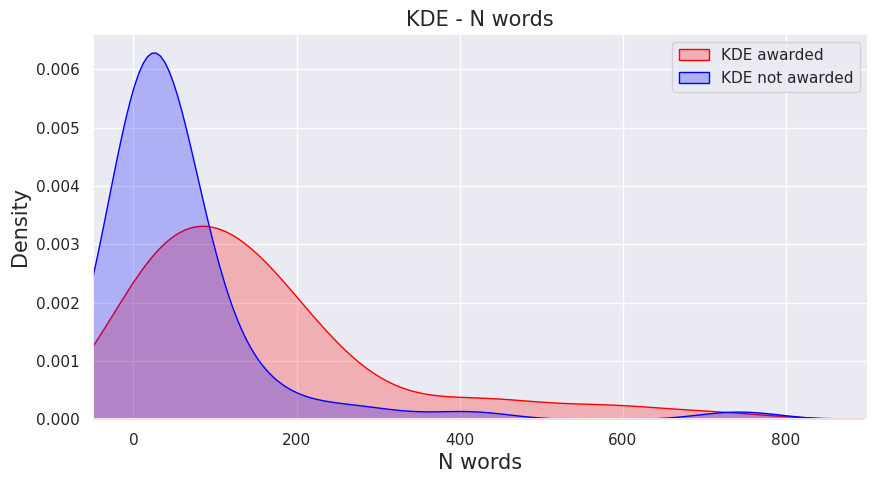

In [ ]:
# import norm
from scipy.stats import norm

words_a=words_a[words_a!=0]
words_na=words_na[words_na!=0]

words_na=np.random.choice(words_na, len(words_a), replace=False)

# plot the 2 kde
plt.figure(figsize=(10,5))
sns.kdeplot(words_a, color='red',label='KDE awarded',fill=True)
sns.kdeplot(words_na, color='blue',label='KDE not awarded',fill=True)
plt.title('KDE - N words',fontsize=15)
plt.xlabel('N words',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.legend(loc='upper right')
plt.xlim(-50,900)
plt.show()